The goal of this assignment is to understand precision-recall in the context of classifiers.

- Use Amazon review data in its entirety.
- Train a logistic regression model.
- Explore various evaluation metrics: accuracy, confusion matrix, precision, recall.
- Explore how various metrics can be combined to produce a cost of making an error.
- Explore precision and recall curves.

In [1]:
import pandas as pd
import numpy as np

# Prepare Data

In [2]:
products = pd.read_csv('amazon_baby.csv')

In [3]:
def remove_punctuation(text):
    import string
    import re
    
    punctuation=string.punctuation #list of puncts
    clean=re.sub(r"[{}]".format(punctuation),"",text)
    
    return clean

In [4]:
products=products.fillna({'review':''})
products['review_clean']=products['review'].apply(remove_punctuation)

In [5]:
# ignore rating 3
products = products[products['rating']!=3]

#rating =>4 are positive, <2 neg
products['sentiment'] = products['rating'].apply(lambda rating: 1 if rating >3 else -1)

In [6]:
train_idx=pd.read_json('module-9-assignment-train-idx.json', typ='series')
test_idx=pd.read_json('module-9-assignment-test-idx.json', typ='series')

In [7]:
train=products.iloc[train_idx]

test=products.iloc[test_idx]

# build word count vector

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [9]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')

train_matrix=vectorizer.fit_transform(train['review_clean'])
test_matrix = vectorizer.transform(test['review_clean'])

In [10]:
train_matrix

<133416x121706 sparse matrix of type '<class 'numpy.int64'>'
	with 7326628 stored elements in Compressed Sparse Row format>

# TRAIN Model

In [11]:
from sklearn.linear_model import LogisticRegression

X_train = train_matrix.copy()
y_train = train['sentiment'].copy()

X_test = test_matrix.copy()
y_test = test['sentiment'].copy()

In [12]:
model=LogisticRegression().fit(X_train, y_train)

# model evaluation

In [13]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy for this model is: {:.3f}'.format(accuracy))

Accuracy for this model is: 0.932


In [14]:
# baseline majority class clf 

baseline = len(test[test['sentiment']==1])/len(test)
print('Baseline accuracy is: {:.3f}'.format(baseline))

Baseline accuracy is: 0.843


# confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix

cmat = confusion_matrix(y_test, y_pred, labels=model.classes_)

In [16]:
print('target_label | predicted_label | count ')
print('-------------+-----------------+-------')
print(cmat)

target_label | predicted_label | count 
-------------+-----------------+-------
[[ 3788  1453]
 [  805 27290]]


In [17]:
conf_table = pd.crosstab(y_test,y_pred, rownames=['True'], 
                         colnames =['Predicted'], margins =True)

In [18]:
conf_table #much better 

Predicted,-1,1,All
True,,,
-1,3788,1453,5241
1,805,27290,28095
All,4593,28743,33336


In [19]:
conf_table.iloc[0,1],
conf_table.iloc[1,0]

805

# computing cost of mistakes

you'd rather put up with false alarms about potentially negative reviews instead of missing negative reviews entirely. In other words, false positives cost more than false negatives. (It may be the other way around for other scenarios, but let's stick with the manufacturer's scenario for now.)

Suppose you know the costs involved in each kind of mistake:

- $100 for each false positive.

- $1 for each false negative.
- Correctly classified reviews incur no cost.

In [20]:
cost_fp=100
cost_fn=1

cost_mistakes = conf_table.iloc[0,1]*cost_fp + conf_table.iloc[1,0]*cost_fn
cost_mistakes

146105

# Precision and Recall


## Precision 

You may not have exact dollar amounts for each kind of mistake. Instead, you may simply prefer to reduce the percentage of false positives to be less than, say, 3.5% of all positive predictions. This is where precision comes in:

prec = [# positive data with positive prediction] / 
        [# all data with positive prediction]

precision = [# tRUE POSITIVE] / [# TRUE POS] + [# FALSE POSITIVE]

So to keep the percentage of false positives below 3.5% of positive predictions, we must raise the precision to 96.5% or higher.

In [21]:
from sklearn.metrics import precision_score
precision = precision_score(y_test, y_pred)
print('Precision on test data is: {:.4f}'.format(precision))

Precision on test data is: 0.9494


In [22]:
false_positive = 1- precision
false_positive

0.05055143861114009

## Recall

recall = [# POS data with POS predictions] / [# all POS data]

recall = [ # TRUE POS] / [#TRUE POS] + [# FALSE NEG]

In [23]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, y_pred)
print("Recall on test data: {:.4f}".format(recall))

Recall on test data: 0.9713


# Precision Recall Trade-off

In [24]:
def apply_threshold(probabilities, thresh):
    
    foo =pd.Series([1 if x>= thresh else -1 for x in probabilities])
    return foo
        

In [36]:
prob=model.predict_proba(X_test)[:,1]

In [38]:
default_predictions = apply_threshold(prob, 0.5)
(default_predictions ==1 ).sum()

28743

In [39]:
high_thres_pred=apply_threshold(prob_5, 0.9)
(high_thres_pred ==1).sum()

25073

In [43]:
precision_default=precision_score(y_test, default_predictions)
recall_default = recall_score(y_test, default_predictions)

print('For the default Threshold of 0.5 the precision is: {:.4f}\n and the Recall is: {:.4f}'.format(precision_default, recall_default))

For the default Threshold of 0.5 the precision is: 0.9494
 and the Recall is: 0.9713


In [44]:
precision_high=precision_score(y_test, high_thres_pred)
recall_high = recall_score(y_test, high_thres_pred)

print('For the Threshold of 0.9 the precision is: {:.4f}\n and the Recall is: {:.4f}'.format(precision_high, recall_high))

For the Threshold of 0.9 the precision is: 0.9815
 and the Recall is: 0.8759


# Precision-recall curve


In [46]:
thresh_values = np.linspace(0.5, 1, num=100)

In [47]:
precision_all=[]
recall_all=[]
for thresh in thresh_values:
    predictions = apply_threshold(prob, thresh)
    precision=precision_score(y_test, predictions)
    precision_all.append(precision)
    
    recall=recall_score(y_test, predictions)
    recall_all.append(recall)

In [50]:
import matplotlib.pyplot as plt
%matplotlib notebook

In [55]:
def plot_pr_curve(precision, recall, title):
    #plt.locator_params(axis='x', nbins=5)
    plt.plot(precision, recall, 'b-', lw=2)
    plt.title(title)
    plt.xlabel('Precision')
    plt.ylabel('Recall')

<IPython.core.display.Javascript object>


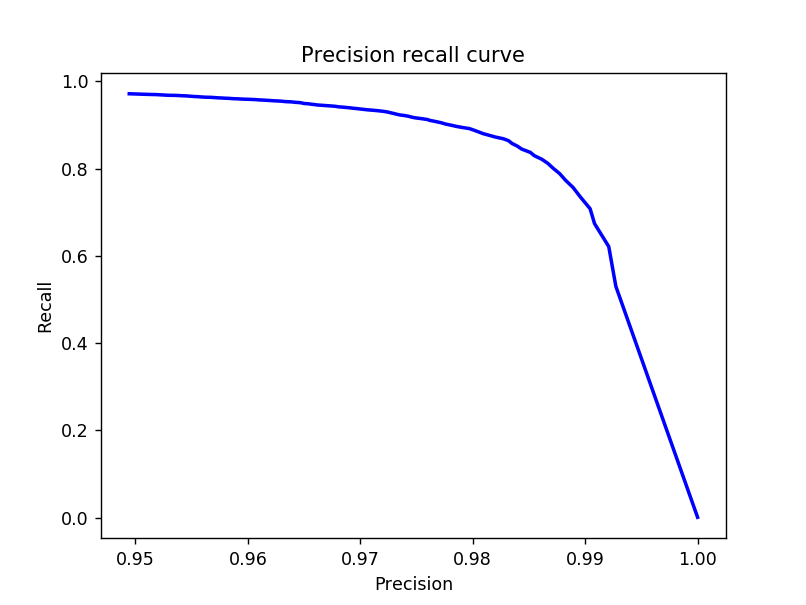

In [148]:
plot_pr_curve(precision_all, recall_all, 'Precision recall curve')

In [93]:
#smallest thresh value that achieves precision >=0.965


In [88]:
df=pd.DataFrame(data={'Threshold':thresh_values, 'Precision':precision_all, 'Recall':recall_all})

In [91]:
df[df['Precision']>=0.965].min()

Precision    0.965365
Recall       0.000569
Threshold    0.712121
dtype: float64

In [94]:
# use thresh of 0.98

super_high_thresh=apply_threshold(prob, 0.98)
conf_table_high = pd.crosstab(y_test,super_high_thresh, rownames=['True'], 
                         colnames =['Predicted'], margins =True)

In [95]:
conf_table_high

Predicted,-1.0,1.0,All
True,,,
-1.0,446,665,1111
1.0,1981,3030,5011
All,2427,3695,6122


# Evaluating specific search terms

select all reviews with the word baby in it

In [122]:
test['name']=test.name.astype(str).str.lower()

C:\Users\Keulando\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [129]:
baby_reviews = test[test['name'].apply(lambda x: 'baby' in x)]

In [130]:
baby_reviews.head()

,name,review,rating,review_clean,sentiment
9,"baby tracker&reg; - daily childcare journal, s...",This has been an easy way for my nanny to reco...,4,This has been an easy way for my nanny to reco...,1
10,"baby tracker&reg; - daily childcare journal, s...",I love this journal and our nanny uses it ever...,4,I love this journal and our nanny uses it ever...,1
56,baby's first year undated wall calendar with s...,I searched high and low for a first year calen...,5,I searched high and low for a first year calen...,1
59,our baby girl memory book,Absolutely love it and all of the Scripture in...,5,Absolutely love it and all of the Scripture in...,1
112,newborn baby tracker&reg; - round the clock ch...,This is the best way to keep track of when you...,5,This is the best way to keep track of when you...,1


In [132]:
baby_matrix=vectorizer.transform(baby_reviews['review_clean'])

In [135]:
proba_baby=model.predict_proba(baby_matrix)[:,1]

In [142]:
y_baby=baby_reviews['sentiment'].copy()

predictions_baby=[apply_threshold(proba_baby, x ) for x in thresh_values] 
precision_baby=[precision_score(y_baby, x) for x in predictions_baby]
recall_baby = [recall_score(y_baby, x) for x in predictions_baby]

In [145]:
df_baby=pd.DataFrame(data={'Threshold':thresh_values, 'Precision':precision_baby, 'Recall':recall_baby})
df_baby[df_baby['Precision'] >=0.965].min()

Precision    0.965988
Recall       0.000545
Threshold    0.732323
dtype: float64

<IPython.core.display.Javascript object>


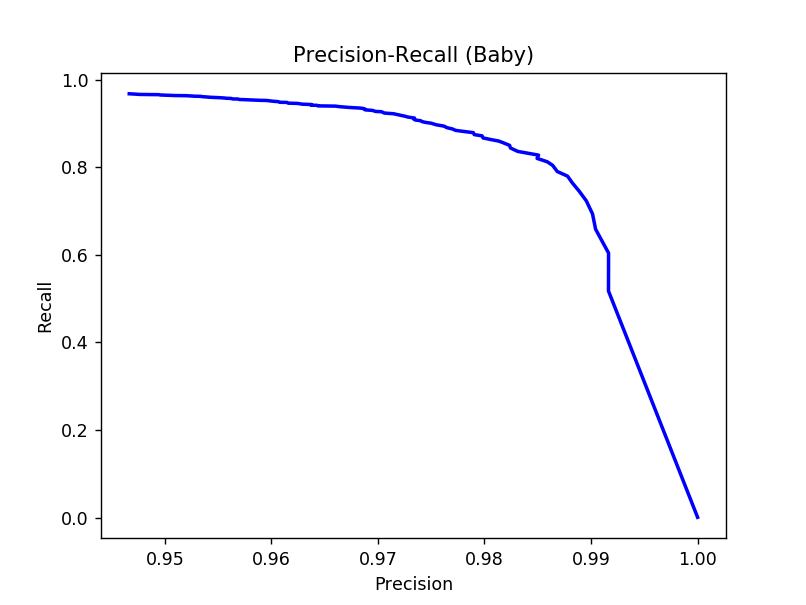

In [149]:
plot_pr_curve(precision_baby, recall_baby, "Precision-Recall (Baby)")